In [2]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

/var/folders/f5/ffqr89k55b92p9wc1t2qc42w0000gn/T/ipykernel_35030/1994989634.py:11: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  provider = IBMQ.load_account()


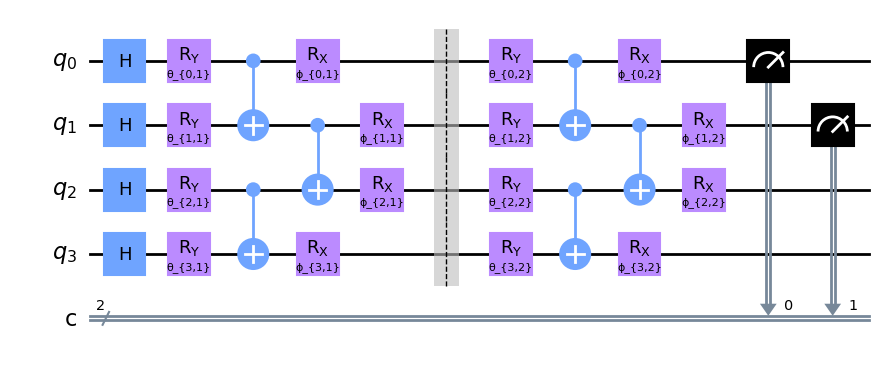

In [3]:
import random
import math
import matplotlib 
from qiskit.circuit import Parameter
n_qubits = 4 
n_meas = 2
p = 0.3

theta_01 = Parameter('θ_{0,1}')
theta_11 = Parameter('θ_{1,1}')
theta_21 = Parameter('θ_{2,1}')
theta_31 = Parameter('θ_{3,1}')
theta_02 = Parameter('θ_{0,2}')
theta_12 = Parameter('θ_{1,2}')
theta_22 = Parameter('θ_{2,2}')
theta_32 = Parameter('θ_{3,2}')

phi_01 = Parameter('ϕ_{0,1}')
phi_11 = Parameter('ϕ_{1,1}')
phi_21 = Parameter('ϕ_{2,1}')
phi_31 = Parameter('ϕ_{3,1}')
phi_02 = Parameter('ϕ_{0,2}')
phi_12 = Parameter('ϕ_{1,2}')
phi_22 = Parameter('ϕ_{2,2}')
phi_32 = Parameter('ϕ_{3,2}')

qc = QuantumCircuit(n_qubits, n_meas)
qc.h([i for i in range(n_qubits)])
#circuit visualization
qc.ry(theta_01, 0)
qc.ry(theta_11, 1)
qc.ry(theta_21, 2)
qc.ry(theta_31, 3)

for i in range(n_qubits//2):   
    qc.cx(2*i,2*i+1)

for i in range(n_qubits//2-1):
    qc.cx(2*i+1,2*i+2)
 
qc.rx(phi_01, 0)
qc.rx(phi_11, 1)
qc.rx(phi_21, 2)
qc.rx(phi_31, 3)

qc.barrier()

qc.ry(theta_02, 0)
qc.ry(theta_12, 1)
qc.ry(theta_22, 2)
qc.ry(theta_32, 3)

for i in range(n_qubits//2):   
    qc.cx(2*i,2*i+1)

for i in range(n_qubits//2-1):
    qc.cx(2*i+1,2*i+2)
    
qc.rx(phi_02, 0)
qc.rx(phi_12, 1)
qc.rx(phi_22, 2)
qc.rx(phi_32, 3)    

qc.measure(0,0)
qc.measure(1,1)
#for i in range(n_qubits):
#    if random.uniform(0,1) < p:
#        qc.measure(i,i)

qc.draw('mpl')

In [20]:
from qiskit.execute_function import execute
from qiskit.result import marginal_counts
##computing variance of gradient for p > 0 
def gradient(n_qubits,L,p,shots,N_reali):

    M_max = n_qubits * L #max number of classical bits
    meas_outcomes_final = ['00', '01', '10', '11']
    gradient_arr = []
    for reali in range(N_reali):
        qc = QuantumCircuit(n_qubits, M_max) 
        qc_p = QuantumCircuit(n_qubits, M_max + 2) # M_max mid-circuit + n_qubits end-of-circuit measurements (<Z_1 Z_2>^\pm)
        qc_m = QuantumCircuit(n_qubits, M_max + 2)
        qc.h([i for i in range(n_qubits)])
        qc_p.h([i for i in range(n_qubits)])
        qc_m.h([i for i in range(n_qubits)])
        M = 0 #number of measurements M < n_meas
        #random.seed(3)
        for t in range(L):
            r = random.uniform(0,1)*2*math.pi
            qc.ry(r, 0)
            qc_p.ry(r+math.pi/2,0) #shift first gate
            qc_m.ry(r-math.pi/2,0)
            for i in range(1,n_qubits):
                r = random.uniform(0,1)*2*math.pi
                qc.ry(r, i)
                qc_p.ry(r,i)
                qc_m.ry(r,i)
                
            for i in range(n_qubits//2):   
                qc.cx(2*i,2*i+1)
                qc_p.cx(2*i,2*i+1)
                qc_m.cx(2*i,2*i+1)

            for i in range(n_qubits//2-1):
                qc.cx(2*i+1,2*i+2)
                qc_p.cx(2*i+1,2*i+2)
                qc_m.cx(2*i+1,2*i+2)

            for i in range(n_qubits):
                r = random.uniform(0,1)*2*math.pi
                qc.rx(r,i)
                qc_p.rx(r,i)
                qc_m.rx(r,i)

            for i in range(n_qubits):
                if random.uniform(0,1) < p:
                    a = qc.measure(i,M)
                    print("measure", a)
                    qc_p.measure(i,M)
                    qc_m.measure(i,M)
                    M += 1
            qc.barrier()        

        qc_p.measure(range(2),range(M,M+2))
        qc_m.measure(range(2),range(M,M+2))
        print(M)
        sim = Aer.get_backend('qasm_simulator')
        job_qc = execute(qc, sim, shots = shots)
        job_qc_p = execute(qc_p, sim, shots = shots)
        job_qc_m = execute(qc_m, sim, shots = shots)
        counts_qc = marginal_counts(job_qc.result(), indices=range(M)).get_counts()
        counts_qc_p = marginal_counts(job_qc_p.result(), indices=range(M)).get_counts()
        counts_qc_p_final = marginal_counts(job_qc_p.result(), indices=range(0,M + 2)).get_counts()
        counts_qc_m = marginal_counts(job_qc_m.result(), indices=range(M)).get_counts()
        counts_qc_m_final = marginal_counts(job_qc_m.result(), indices=range(0,M + 2)).get_counts()

        proba_p = {}
        proba = {}
        ZZ_p = {}
        print(counts_qc)
        for meas_string_mid in counts_qc:
            probs = {}
            for meas_string_final in meas_outcomes_final:
                meas_string_total = meas_string_final + meas_string_mid
                #print("meas_fin ", meas_string_final, " meas_mid ", meas_string_mid, " meas_tot ", meas_string_total,"\n")
                proba[meas_string_mid] = counts_qc[meas_string_mid]/shots
                if meas_string_total in counts_qc_p_final:
                    probs[meas_string_final] = counts_qc_p_final[meas_string_total]/shots
                    proba_p[meas_string_mid] = counts_qc_p[meas_string_mid]/shots
                    #print("proba_p ", proba_p[meas_string_mid])
                else:
                    probs[meas_string_final] = 0
                    proba_p[meas_string_mid] = 0
            ZZ_p[meas_string_mid] = probs['00'] + probs['11'] - probs['01'] - probs['10']

        proba_m = {}
        ZZ_m = {}
        for meas_string_mid in counts_qc:
            probs = {}
            for meas_string_final in meas_outcomes_final:
                meas_string_total = meas_string_final + meas_string_mid
                if meas_string_total in counts_qc_m_final:
                    probs[meas_string_final] = counts_qc_m_final[meas_string_total]/shots
                    proba_m[meas_string_mid] = counts_qc_m[meas_string_mid]/shots
                else:
                    probs[meas_string_final] = 0
                    proba_m[meas_string_mid] = 0
            ZZ_m[meas_string_mid] = probs['00'] + probs['11'] - probs['01'] - probs['10']

        gradient = 0
        for meas_string_mid in counts_qc:
            gradient += 0.5*(ZZ_p[meas_string_mid]*proba_p[meas_string_mid]/proba[meas_string_mid] - ZZ_m[meas_string_mid]*proba_m[meas_string_mid]/proba[meas_string_mid])
        gradient_arr.append(gradient)
        if reali%10==0:
            print(reali, " ", M, " ", np.var(gradient_arr), "\n")
    return np.var(gradient_arr)

n_qubits = 4
L = 3
p = 0.2 
shots = 2**4
N_reali = 100
print("gradient variance = ", gradient(n_qubits,L,p,shots,N_reali))   
#print(probs['00']+probs['11']-probs['01']-probs['10'])
#print("Sim meas 1 result: ", counts_qc_p)
#print("Sim meas 2 result: ", counts_qc_p_final)
#print("Sim meas 3 result: ", counts_qc_p_final_2)
#print("Sim meas 4 result: ", ZZ_p)
#qc.draw('mpl')    

measure <qiskit.circuit.instructionset.InstructionSet object at 0x7fe0c3dcd0c0>
measure <qiskit.circuit.instructionset.InstructionSet object at 0x7fe0c3dcd0f0>
measure <qiskit.circuit.instructionset.InstructionSet object at 0x7fe0c3dcd180>
measure <qiskit.circuit.instructionset.InstructionSet object at 0x7fe0bcd81de0>
measure <qiskit.circuit.instructionset.InstructionSet object at 0x7fe0bcd82170>
5
{'11100': 2, '10100': 1, '10000': 1, '00000': 2, '11101': 2, '00100': 2, '01000': 2, '01100': 4}
0   5   0.0 

measure <qiskit.circuit.instructionset.InstructionSet object at 0x7fe0c3dccb50>
measure <qiskit.circuit.instructionset.InstructionSet object at 0x7fe0c3dcd480>
measure <qiskit.circuit.instructionset.InstructionSet object at 0x7fe0bcd81d80>
3
{'111': 3, '000': 1, '010': 6, '101': 1, '110': 5}
measure <qiskit.circuit.instructionset.InstructionSet object at 0x7fe0c3dccb80>
measure <qiskit.circuit.instructionset.InstructionSet object at 0x7fe0bcdbafb0>
2
{'01': 3, '11': 1, '00': 2, '10'

QiskitError: 'No counts for experiment "0"'

In [5]:
##computing variance of gradient for p = 0
from qiskit.execute_function import execute
from qiskit.result import marginal_counts

n_qubits = 4
L = 4
p = 0.0
shots = 2**8 
N_reali = 100

M_max = n_qubits * L #max number of classical bits
meas_outcomes_final = ['00', '01', '10', '11']
gradient_arr = []
for it in range(N_reali):
    qc = QuantumCircuit(n_qubits, M_max) 
    qc_p = QuantumCircuit(n_qubits, M_max + 2) # M_max mid-circuit + n_qubits end-of-circuit measurements (<Z_1 Z_2>^\pm)
    qc_m = QuantumCircuit(n_qubits, M_max + 2)
    #random.seed(1)
    qc.h([i for i in range(n_qubits)])
    qc_p.h([i for i in range(n_qubits)])
    qc_m.h([i for i in range(n_qubits)])
    M = 0 #number of measurements M < n_meas
    if it%10==0:
        print(it)
    #random.seed(it+1000)
    for t in range(L):
        r = random.uniform(0,1)*2*math.pi
        qc.ry(r, 0)
        qc_p.ry(r+math.pi/2,0) #shift first gate
        qc_m.ry(r-math.pi/2,0)
        for i in range(1,n_qubits):
            r = random.uniform(0,1)*2*math.pi
            qc.ry(r, i)
            qc_p.ry(r,i)
            qc_m.ry(r,i)
        for i in range(n_qubits//2):   
            qc.cx(2*i,2*i+1)
            qc_p.cx(2*i,2*i+1)
            qc_m.cx(2*i,2*i+1)

        for i in range(n_qubits//2-1):
            qc.cx(2*i+1,2*i+2)
            qc_p.cx(2*i+1,2*i+2)
            qc_m.cx(2*i+1,2*i+2)

        for i in range(n_qubits):
            r = random.uniform(0,1)*2*math.pi
            qc.rx(r,i)
            qc_p.rx(r,i)
            qc_m.rx(r,i)

        for i in range(n_qubits):
            if random.uniform(0,1) < p:
                qc.measure(i,M)
                qc_p.measure(i,M)
                qc_m.measure(i,M)
                M += 1
        qc.barrier()        

    qc_p.measure(range(2),range(M,M+2))
    qc_m.measure(range(2),range(M,M+2))

    sim = Aer.get_backend('qasm_simulator')
    job_qc = execute(qc, sim, shots = shots, seed_simulator = it)
    job_qc_p = execute(qc_p, sim, shots = shots, seed_simulator = it)
    job_qc_m = execute(qc_m, sim, shots = shots, seed_simulator = it)
    counts_qc_p_final = marginal_counts(job_qc_p.result(), indices=range(0,M + 2)).get_counts()
    counts_qc_m_final = marginal_counts(job_qc_m.result(), indices=range(0,M + 2)).get_counts()

    probs = {}
    for meas_string_final in meas_outcomes_final:
        meas_string_total = meas_string_final 
        if meas_string_total in counts_qc_p_final:
            probs[meas_string_final] = counts_qc_p_final[meas_string_total]/shots
        else:
            probs[meas_string_final] = 0
    ZZ_p = probs['00'] + probs['11'] - probs['01'] - probs['10']

    probs = {}
    for meas_string_final in meas_outcomes_final:
        meas_string_total = meas_string_final 
        if meas_string_total in counts_qc_m_final:
            probs[meas_string_final] = counts_qc_m_final[meas_string_total]/shots
        else:
            probs[meas_string_final] = 0
    ZZ_m = probs['00'] + probs['11'] - probs['01'] - probs['10']


    gradient = 0.5*(ZZ_p - ZZ_m)
    gradient_arr.append(gradient)
print(np.var(gradient_arr))    
#qc.draw('mpl')

0
10
20
30
40
50
60
70
80
90
0.027413995361328127


In [8]:
print(counts_qc_p_final)
print(M)
print(job_qc_p.result())

{'01': 54, '00': 19, '10': 92, '11': 91}
0
Result(backend_name='qasm_simulator', backend_version='0.11.2', qobj_id='e24c0475-a85d-4e6b-8ed3-3afed1b467f1', job_id='f5473754-12bf-4432-9f63-51eb9a1482a5', success=True, results=[ExperimentResult(shots=256, success=True, meas_level=2, data=ExperimentResultData(counts={'0x1': 54, '0x0': 19, '0x2': 92, '0x3': 91}), header=QobjExperimentHeader(clbit_labels=[['c', 0], ['c', 1], ['c', 2], ['c', 3], ['c', 4], ['c', 5], ['c', 6], ['c', 7], ['c', 8], ['c', 9], ['c', 10], ['c', 11], ['c', 12], ['c', 13], ['c', 14], ['c', 15], ['c', 16], ['c', 17]], creg_sizes=[['c', 18]], global_phase=4.7148826184857136, memory_slots=18, metadata={}, n_qubits=4, name='circuit-725', qreg_sizes=[['q', 4]], qubit_labels=[['q', 0], ['q', 1], ['q', 2], ['q', 3]]), status=DONE, seed_simulator=99, metadata={'parallel_state_update': 8, 'parallel_shots': 1, 'sample_measure_time': 0.000176042, 'noise': 'ideal', 'batched_shots_optimization': False, 'remapped_qubits': False, 'd